# Reference Mapping Using cell embedding by pretrained scGPT model

In this tutorial, we demonstrate how to use the scGPT model to embed cells and map them to referenced embeddings. Then the meta labels of the reference cells, such as cell type or disease conditions, can be propagated to the query cells. Particularly, we use the `scGPT_human` model to provide embedings out of the box. In this zero-shot settings, no further training is needed. All the workflow can be completed pretty fast and we observed considerable accuracy.

The pancreas dataset is used in this example. Please download it from https://drive.google.com/drive/folders/1s9XjcSiPC-FYV3VeHrEa7SeZetrthQVV?usp=sharing.

We provide two mode of reference mapping in the following:

1. **Using a customized reference dataset with provided annotations**. Mapping unkown cells in a query set to this reference dataset. This illustrated the use case for users who already have annotations for similar samples and want to quickly transfer the annotation to the newly collected samples.

2. **Using our previously collected over 33 million cells from CellXGene as reference**. Mapping unkown cells in a query set to this reference atlas. This illustrates a generic use case for users who want to map their own data to a large reference atlas. For example, this can be a fast first step to understand the cell composition of a newly collected samples.

According to your use case, you may only need **apply one of the two modes**.

**Note**: please note that the reference mapping is a new experimental feature.


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings
import pickle
import anndata as ann
from anndata import AnnData
sys.path.insert(0, "../")
import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [19]:
sc.tl.rank_genes_groups(colon_adata, groupby='cell_type', method='t-test')

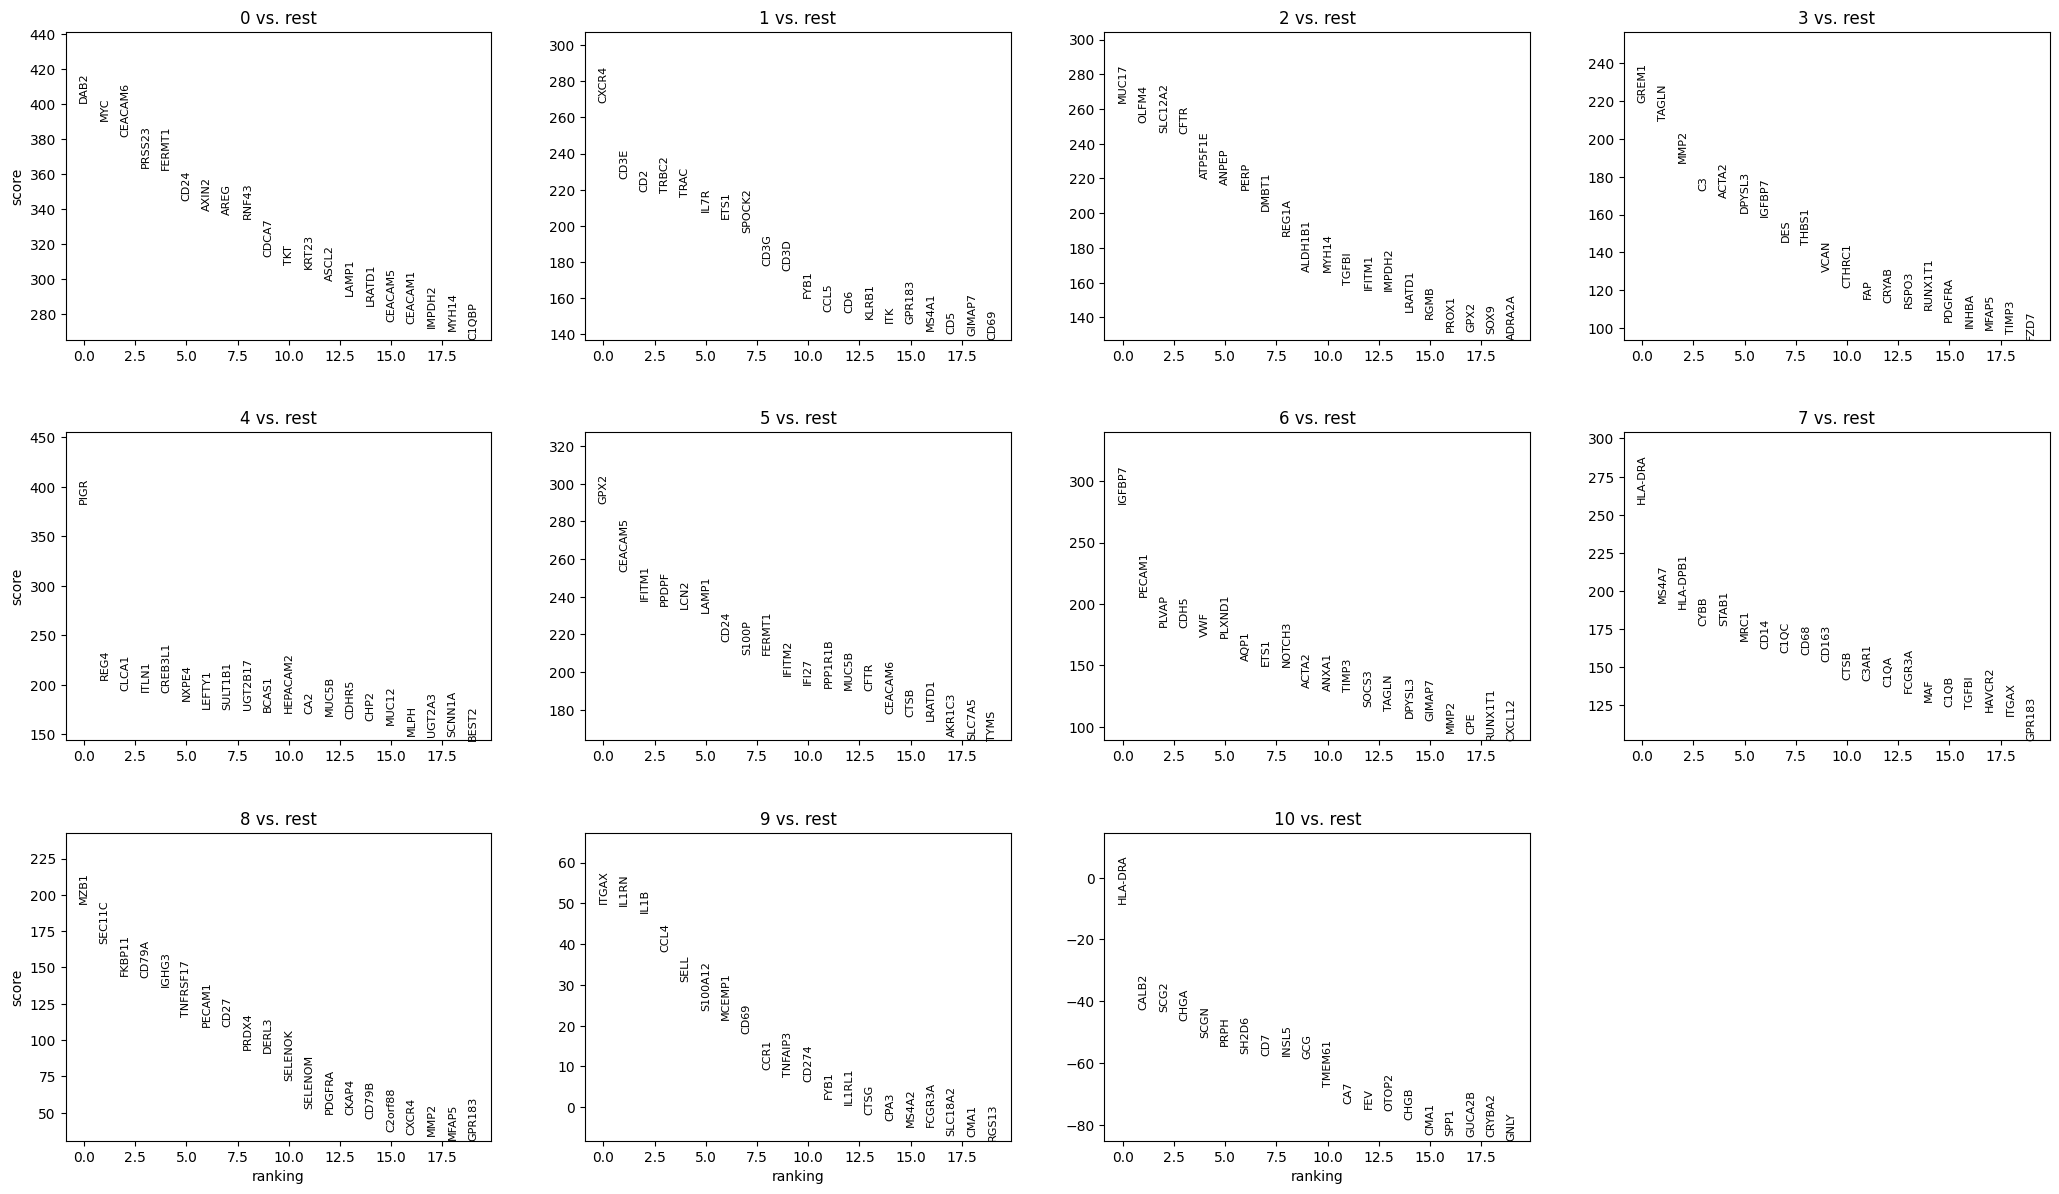

In [21]:
sc.pl.rank_genes_groups(colon_adata, n_genes=20, sharey=False)

In [2]:
mouse_adata = sc.read_h5ad('/home/whytin/Research/Project/V2-15.h5ad')

In [12]:
mouse_adata

AnnData object with n_obs × n_vars = 1068 × 16628
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'PCA', 'UMAP', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Referrence mapping using a customized reference dataset

In [2]:
from scipy.stats import pearsonr
def get_pcc(adata1,adata2,dim=1,func=pearsonr):
    r1,p1=[],[]
    for g in range(adata1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g])
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:])
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def cal_PCC_features(target, predict):
      n_features = target.shape[1]
      # 存储每个特征的皮尔森相关系数
      pcc_values = []
      # 按照每个特征计算皮尔森相关系数
      for i in range(n_features):
          label_feature = target[:, i].flatten()
          prediction_feature = predict[:, i].flatten()
          # 计算皮尔森相关系数
          corr, _ = pearsonr(label_feature, prediction_feature)
          # 将结果添加到列表
          pcc_values.append(corr)
      return pcc_values       

import faiss
def search_idx(ref_emb, map_emb, k_neighbors):
	k=k_neighbors
	index = faiss.IndexFlatL2(ref_emb.shape[1])
	index.add(ref_emb)
	# Query dataset, k - number of closest elements (returns 2 numpy arrays)
	distances, labels = index.search(map_emb, k)
	return labels

def gene_fusion(idx, gene_ref, ref_num=50):
	val_mean_output = []
	for i in range(len(idx)):
		k_neighbor = []
		print(i)
		for j in idx[i][:ref_num]:
			k_neighbor.append(gene_ref[j])
		val_mean_output.append(np.mean(np.array(k_neighbor), axis=0))
	return np.array(val_mean_output)

def align_gene_order_and_modify_var(adata1, adata2):
    # 获取 raw_adata1_common 的 gene_id 顺序
    gene_order_adata1 = adata1.var['gene_id'].values
    
    # 根据 raw_adata1_common 的 gene_id 顺序重新排列 raw_adata2_common
    # 使用 pd.Index 对齐顺序
    adata2 = adata2[:, adata2.var['gene_id'].isin(gene_order_adata1)]  # 保证只保留相同基因
    adata2 = adata2[:, pd.Index(adata2.var['gene_id'].values).get_indexer(gene_order_adata1)]  # 按照 adata1 的顺序排序

    # 修改 raw_adata2_common 的 var['gene_id'] 以匹配 raw_adata1_common
    adata2.var['gene_id'] = gene_order_adata1

    return adata2


def combine_two_adata(adata, test_adata):
    # 获取 raw_adata1 和 raw_adata2 中的基因名称

    genes_adata1 = adata.var['gene_id']
    genes_adata2 = test_adata.var['gene_id']

    # 找到两个数据集的共同基因（交集）
    common_genes = genes_adata1[genes_adata1.isin(genes_adata2)].values

    # 提取包含共同基因的表达矩阵
    raw_adata1_common = adata[:, adata.var['gene_id'].isin(common_genes)]
    raw_adata2_common = test_adata[:, test_adata.var['gene_id'].isin(common_genes)]

    raw_adata2_common = align_gene_order_and_modify_var(raw_adata1_common, raw_adata2_common)

    raw_adata1_common.var_names = [str(i) for i in range(len(common_genes))]
    raw_adata2_common.var_names = [str(i) for i in range(len(common_genes))]
    # 合并两个数据集
    #raw_adata1_common.obs['batch_id']=raw_adata1_common.obs['batch']
    raw_adata2_common.obs['batch_id']='5'
    combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')
    #combined_adata = ann.concat([raw_adata1_common, raw_adata2_common])
    #combined_adata = ann.concat([raw_adata1_common,raw_adata2_common], label='batch', keys=[None, '2'])
    #combined_adata = remove_zero_expression_cells(combined_adata)

    return combined_adata
    # 可以选择保存结果，或者后续进行分析
    # combined_adata.write('combined_adata.h5ad')


In [3]:

def normalize_adata(adata, scale=1e6, smooth=False):# type: ignore
    """
    Normalize each spot by total gene counts + Logarithmize each spot
    """
    
    import scanpy as sc
    
    filtered_adata = adata.copy()
    
    if smooth:
        adata_df = adata.to_df()
        for index, df_row in adata.obs.iterrows():
            row = int(df_row['array_row'])
            col = int(df_row['array_col'])
            neighbors_index = adata.obs[((adata.obs['array_row'] >= row - 1) & (adata.obs['array_row'] <= row + 1)) & \
                ((adata.obs['array_col'] >= col - 1) & (adata.obs['array_col'] <= col + 1))].index
            neighbors = adata_df.loc[neighbors_index]
            nb_neighbors = len(neighbors)
            
            avg = neighbors.sum() / nb_neighbors
            filtered_adata[index] = avg
    
    
    sc.pp.normalize_total(filtered_adata, target_sum=1, inplace=True)
    # Facilitate training when using the MSE loss. 
    # This'trick' is also used by Y. Zeng et al in "Spatial transcriptomics prediction from histology jointly through Transformer and graph neural networks"
    filtered_adata.X = filtered_adata.X * scale 
    
    # Logarithm of the expression
    sc.pp.log1p(filtered_adata) 
    filtered_adata.raw = adata

    return filtered_adata

In [4]:
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm

def compute_spot_gene(adata, window_size=200):
    coords = adata.obsm['spatial']
    radius = window_size // 2
    X = adata.X
    n_cells = coords.shape[0]
    
    is_sparse = sp.issparse(X)
    spot_gene = []

    for i in tqdm(range(n_cells), desc="Computing spot_gene"):
        xi, yi = coords[i]
        dx = np.abs(coords[:, 0] - xi)
        dy = np.abs(coords[:, 1] - yi)
        mask = (dx <= radius) & (dy <= radius)
        if is_sparse:
            summed = X[mask].sum(axis=0).A1 # flatten sparse sum to 1D array
        else:
            summed = X[mask].sum(axis=0)
        spot_gene.append(summed)

    adata.obsm['spot_gene'] = np.vstack(spot_gene)
    new_adata = ann.AnnData(X=adata.obsm['spot_gene'])
    new_adata.var_names = adata.var_names
    sc.pp.normalize_total(new_adata, target_sum=1e6, inplace=True)
    sc.pp.log1p(new_adata)
    adata.obsm['spot_gene_norm'] = new_adata.X
    return adata

In [5]:
def remove_zero_expression_cells(adata):
    # 检查每个细胞是否所有基因的表达值都为0
    non_zero_cells = (adata.X != 0).sum(axis=1) > 0  # 只保留至少有一个非零表达的细胞
    adata = adata[non_zero_cells, :]
    return adata

In [6]:
model_dir = Path("../save/scGPT_human")
#model_dir = Path("/home/whytin/Research/Project/scGPT/save/Breast_finetune2")
#model_dir = Path("../save/scGPT_CP")
#adata = sc.read_h5ad("../data/annotation_pancreas/demo_train.h5ad")
cell_type_key = "celltype"
gene_col = "gene_id"

In [44]:
xenium_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer94_cell_HEST_noimg.h5ad')

In [8]:
xenium_adata99 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer99_cell_HEST_noimg.h5ad')

In [45]:
xenium_adata

AnnData object with n_obs × n_vars = 355825 × 274
    obs: 'in_tissue', 'n_counts'
    uns: 'log1p', 'spatial', 'wsi_shape'
    obsm: 'cell_gene_embed', 'spatial', 'virchow2_cell_embed'

In [10]:
xenium_adata99

AnnData object with n_obs × n_vars = 889496 × 274
    obs: 'in_tissue', 'n_counts', 'cell_type'
    uns: 'log1p', 'spatial', 'wsi_shape'
    obsm: 'cell_gene_embed', 'spatial', 'virchow2_cell_embed'

In [8]:
xenium_adata1 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer785_cell_HEST_noimg.h5ad')

In [13]:
xenium_adata94 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer94_cell_HEST.h5ad')

In [46]:
xenium_adata1 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer149_cell_HEST_noimg.h5ad')

In [17]:
xenium_adata = normalize_adata(xenium_adata)

In [12]:
xenium_adata1

AnnData object with n_obs × n_vars = 165156 × 306
    obs: 'in_tissue', 'n_counts', 'cell_type'
    uns: 'log1p', 'noseq_spatial', 'noseq_virchow2_cell_embed', 'noseq_virchow2_embed', 'spatial', 'wsi_shape'
    obsm: 'cell_allgene_embed', 'scGPT_cell_embed', 'spatial', 'spot_embed', 'spot_gene', 'virchow2_cell_embed', 'virchow2_embed'

In [25]:
xenium_adata94 = normalize_adata(xenium_adata94)

/tmp/ipykernel_3436850/2452063104.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


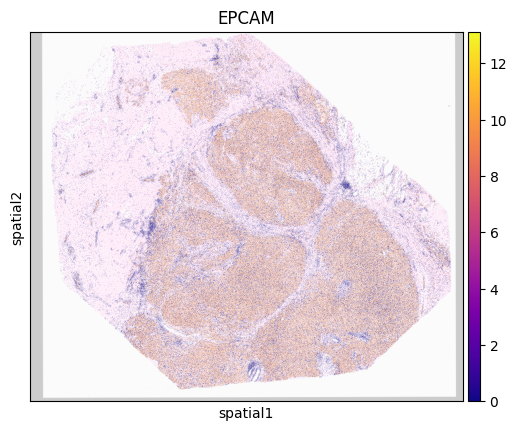

In [27]:
sc.pl.spatial(
    xenium_adata94,
    color="EPCAM",        
    img_key='downscaled_fullres',          # 也可选，默认使用 'hires' 或 'lowres'
    spot_size=30,
    cmap="plasma",
    use_raw=False,
    alpha=1,         # 点不透明
    alpha_img=0.2, 
    crop_coord=(0, xenium_adata94.uns['wsi_shape'][1], 0, xenium_adata94.uns['wsi_shape'][0])
)

In [ ]:
source = xenium_adata.var_names.values
target = xenium_adata99.var_names.values
indices = [list(source).index(val) for val in list(target) if val in list(source)]
xenium_adata = xenium_adata[:, indices]
#raw_adata = ann.AnnData(X=xenium_adata.raw.X)
#xenium_adata.raw = raw_adata[:, indices]

In [20]:
source = xenium_adata.var_names.values
target = xenium_adata99.var_names.values
indices = [list(source).index(val) for val in list(target) if val in list(source)]
xenium_adata = xenium_adata[:, indices]
raw_adata = ann.AnnData(X=xenium_adata.raw.X)
xenium_adata.raw = raw_adata[:, indices]

In [62]:
ref_adata = ann.AnnData(X=xenium_adata.X)
ref_adata.var['gene_id'] = xenium_adata.var_names.values

In [63]:
crc_embed_adata = scg.tasks.embed_data(
    ref_adata,
    model_dir,
    #max_length=307,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
    use_all_gene=False,
)

after version
scGPT - INFO - match 274/274 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 5560/5560 [08:04<00:00, 11.48it/s]
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:301: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [14]:
gene_bool = ref_adata.var['id_in_vocab'].values>0

In [15]:
xenium_adata = xenium_adata[:, gene_bool]

In [60]:
xenium_adata = remove_zero_expression_cells(xenium_adata)

In [63]:
xenium_adata = compute_spot_gene(xenium_adata)

Computing spot_gene: 100%|██████████| 306429/306429 [05:50<00:00, 873.04it/s]
/tmp/ipykernel_3470763/3568244479.py:25: ImplicitModificationWarning: Setting element `.obsm['spot_gene']` of view, initializing view as actual.
  adata.obsm['spot_gene'] = np.vstack(spot_gene)


In [61]:
xenium_adata = normalize_adata(xenium_adata)

In [19]:
xenium_adata.raw.X.shape

(889496, 274)

In [47]:
xenium_adata.X

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 11.473715,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 11.578686,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [64]:
xenium_adata.obsm['cell_gene_embed'] = crc_embed_adata.obsm['X_scGPT']

In [26]:
xenium_adata

AnnData object with n_obs × n_vars = 355825 × 274
    obs: 'in_tissue', 'n_counts'
    uns: 'log1p', 'spatial', 'wsi_shape'
    obsm: 'cell_gene_embed', 'spatial', 'virchow2_cell_embed'

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 274 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

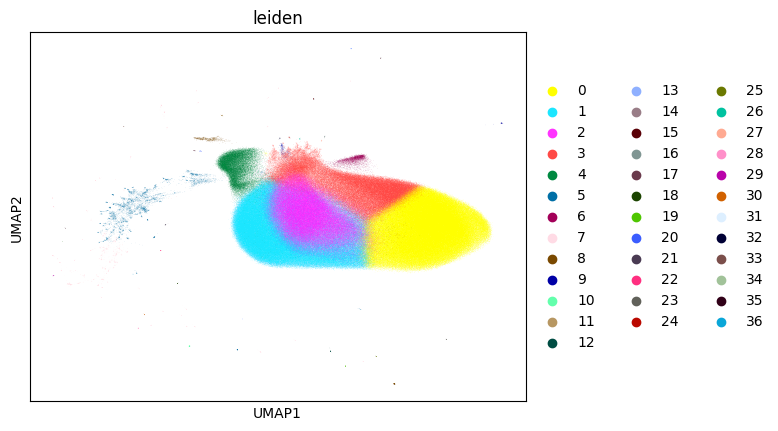

In [27]:
import anndata as ann
he_adata = ann.AnnData(X=xenium_adata.X)
sc.pp.neighbors(he_adata)
sc.tl.umap(he_adata)
sc.tl.leiden(he_adata, resolution=0.5)
sc.pl.umap(he_adata, color=['leiden'])

In [28]:
xenium_adata.obs['cell_type'] = he_adata.obs['leiden'].values

In [65]:
xenium_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer94_cell_HEST_noimg.h5ad')

In [107]:
xenium_adata.var['gene_id'] = xenium_adata.var_names.values

In [47]:
xenium_adata.var['gene_id'] = xenium_adata.var_names.values
xenium_adata99.var['gene_id'] = xenium_adata99.var_names.values
combined_adata = combine_two_adata(combined_adata, xenium_adata)

/tmp/ipykernel_1888256/867552534.py:58: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata2.var['gene_id'] = gene_order_adata1
/tmp/ipykernel_1888256/867552534.py:83: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')


In [7]:
combined_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer_combined.h5ad')

In [17]:
np.unique(combined_adata.obs['batch_id'].values)

array(['0', '1', '2'], dtype=object)

In [43]:
combined_adata

AnnData object with n_obs × n_vars = 3284452 × 274
    obs: 'in_tissue', 'n_counts', 'cell_type', 'batch', 'batch_id'
    var: 'gene_id'
    obsm: 'cell_gene_embed', 'spatial', 'virchow2_cell_embed'

/tmp/ipykernel_1906397/45980426.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combined_adata, resolution=0.5)


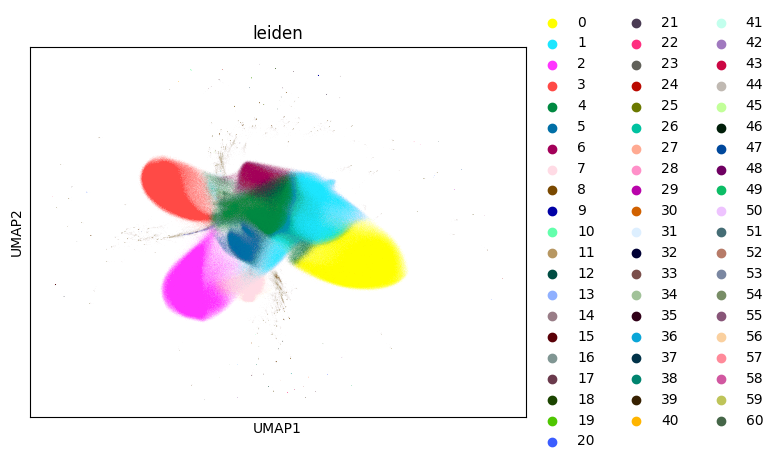

In [11]:
sc.tl.leiden(combined_adata, resolution=0.5)
sc.pl.umap(combined_adata, color=['leiden'])

In [12]:
combined_adata.obs['cell_type'] = combined_adata.obs['leiden'].values

In [13]:
combined_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer_combined_training.h5ad')

In [14]:
combined_adata

AnnData object with n_obs × n_vars = 3640277 × 274
    obs: 'in_tissue', 'n_counts', 'cell_type', 'batch', 'batch_id', 'leiden'
    var: 'gene_id'
    uns: 'pca', 'neighbors', 'umap', 'batch_id_colors', 'leiden', 'leiden_colors'
    obsm: 'cell_gene_embed', 'spatial', 'virchow2_cell_embed', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 274 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. Thi

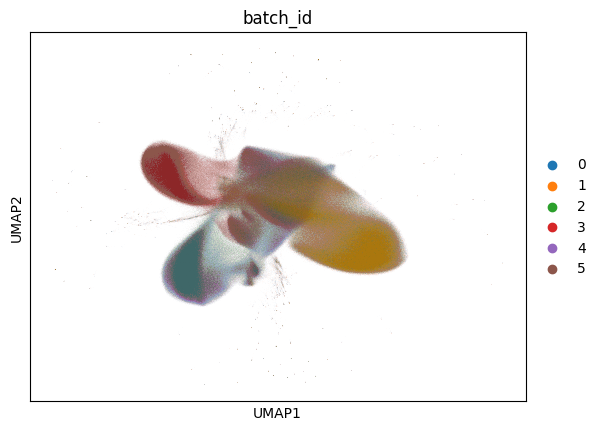

In [10]:
sc.pp.neighbors(combined_adata)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color='batch_id')

In [71]:
xenium_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer149_cell_HEST_noimg.h5ad')

In [93]:
xenium_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer_ref.h5ad')

In [66]:
col_bool = (xenium_adata.X != 0).sum(axis=1) > 0 

In [67]:
xenium_adata = xenium_adata[col_bool, :]

In [69]:
xenium_adata.obsm['spot_gene'] = xenium_adata.obsm['spot_gene'][:, gene_bool]

/tmp/ipykernel_1703853/557452674.py:1: ImplicitModificationWarning: Setting element `.obsm['spot_gene']` of view, initializing view as actual.
  xenium_adata.obsm['spot_gene'] = xenium_adata.obsm['spot_gene'][:, gene_bool]


In [74]:
xenium_adata.raw = raw_data

In [76]:
xenium_adata.raw.X.shape

(109726, 306)

In [73]:
raw_data = ann.AnnData(X=xenium_adata.raw.X)
raw_data = raw_data[:, gene_bool]

In [15]:
xenium_adata

AnnData object with n_obs × n_vars = 165156 × 306
    obs: 'in_tissue', 'n_counts'
    uns: 'log1p', 'noseq_spatial', 'noseq_virchow2_cell_embed', 'noseq_virchow2_embed', 'spatial', 'wsi_shape'
    obsm: 'scGPT_cell_embed', 'spatial', 'spot_embed', 'spot_gene', 'virchow2_cell_embed', 'virchow2_embed', 'cell_allgene_embed'

In [3]:
xenium_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer784_cell_HEST.h5ad')

In [5]:
xenium_adata_148 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer148_cell_HEST.h5ad')

In [40]:
xenium_adata_149 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer149_cell_HEST.h5ad')

In [37]:
xenium_adata_149.write('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer149_cell_HEST.h5ad')

In [8]:
import pickle
with open('/mnt/DATA16T/Xenium/gene_list_147', 'rb') as f:
	gene_lt = pickle.load(f)

In [12]:
xenium_adata_148 = normalize_adata(xenium_adata_148)

In [33]:
xenium_adata_149 = normalize_adata(xenium_adata_149)

In [34]:
xenium_adata_149 = compute_spot_gene(xenium_adata_149)

Computing spot_gene: 100%|██████████| 306446/306446 [06:00<00:00, 849.79it/s]


In [20]:
xenium_adata_148 = compute_spot_gene(xenium_adata_148)

Computing spot_gene: 100%|██████████| 338122/338122 [07:01<00:00, 801.60it/s]


In [ ]:
gene_bool = np.isin(gene_lt, xenium_adata_148.var_names.values)

In [22]:
xenium_adata_148.obsm['spot_gene'][0]

array([7.8363037 , 7.441517  , 1.2622645 , 9.420201  , 5.6994853 ,
       9.032652  , 3.2057238 , 0.7334882 , 7.7374516 , 4.3061566 ,
       4.8962293 , 6.721222  , 0.74529815, 0.3907325 , 7.784359  ,
       7.4964414 , 9.330278  , 1.2868257 , 9.192231  , 8.520926  ,
       4.755299  , 3.4718714 , 5.4086175 , 7.9558983 , 9.210463  ,
       3.162598  , 0.6749425 , 5.752376  , 8.272521  , 6.9118876 ,
       1.8850259 , 4.244071  , 3.8805485 , 2.9289255 , 2.2144177 ,
       3.1739736 , 3.2423337 , 0.3181463 , 7.8182635 , 0.60024637,
       3.5646422 , 4.0024505 , 7.1773195 , 0.62045544, 8.023431  ,
       8.379495  , 0.        , 7.439291  , 5.4663196 , 8.230424  ,
       5.028298  , 9.325021  , 2.5418444 , 6.1455717 , 0.        ,
       1.0667478 , 3.1620915 , 0.6151822 , 0.        , 0.33112755,
       0.40263298, 2.8174245 , 2.6327124 , 0.9244826 , 6.4982705 ,
       0.        , 0.6048114 , 0.        , 2.1580212 , 2.9097884 ,
       7.092515  , 1.5610242 , 2.9406302 , 4.6607246 , 6.34209

In [8]:
spot_adata = xenium_adata.copy()

In [17]:
gene_bool = np.isin(gene_lt, spot_adata.var['gene_id'].values)

In [19]:
spot_adata.X = xenium_adata.obsm['raw_data'][:, gene_bool]

In [24]:
spot_adata = normalize_adata(spot_adata, smooth=True)

KeyError: 'array_row'

In [7]:
def compute_spot_gene_weighted(adata, window_size=200, sigma=50):
    coords = adata.obsm['spatial']
    radius = window_size // 2
    X = adata.X
    n_cells = coords.shape[0]
    
    is_sparse = sp.issparse(X)
    spot_gene = []

    for i in tqdm(range(n_cells), desc="Weighted gene expression"):
        xi, yi = coords[i]
        dx = coords[:, 0] - xi
        dy = coords[:, 1] - yi
        dist_sq = dx**2 + dy**2
        mask = (np.abs(dx) <= radius) & (np.abs(dy) <= radius)

        if not np.any(mask):
            spot_gene.append(np.zeros(X.shape[1]))
            continue

        weights = np.exp(-dist_sq[mask] / (2 * sigma**2))
        weights /= weights.sum()  # normalize

        if is_sparse:
            weighted_expr = X[mask].multiply(weights[:, np.newaxis]).sum(axis=0).A1
        else:
            weighted_expr = (X[mask].T @ weights).T  # dot product

        spot_gene.append(weighted_expr)

    adata.obsm['spot_gene'] = np.vstack(spot_gene)
    return adata

In [73]:
xenium_adata = compute_spot_gene(xenium_adata)

Computing spot_gene: 100%|██████████| 275120/275120 [04:37<00:00, 992.95it/s] 


In [40]:
xenium_adata.X[0]

array([ 0.      , 10.483335,  0.      ,  9.384778, 10.994148,  0.      ,
       10.077883, 11.330616, 10.077883,  0.      ,  0.      ,  0.      ,
        0.      , 11.464146,  9.384778,  9.384778,  9.384778,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  9.384778,  0.      ,
        9.384778,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        9.384778, 11.176467,  9.384778,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ], dtype=float32)

In [72]:
xenium_adata.obsm['spot_gene'][0]

array([ 10.054354, 143.36711 ,  11.012167, 118.47748 , 118.07048 ,
        30.22586 ,  69.73712 , 124.38903 , 121.25314 ,  89.308044,
        66.36683 ,  79.459305,   0.      ,  82.23071 , 293.68417 ,
        46.936703, 304.82898 ,  26.910683,  50.02897 , 208.78673 ,
        27.885632,  81.28971 ,  18.923695,  49.69684 ,  84.84272 ,
        65.972786,  71.09217 ,   9.161655,  28.479038,  89.052635,
       109.66818 , 209.65263 ,  67.315765,  47.367912,  57.665417,
        18.787579,  18.08695 ,  18.846413,  56.11831 , 202.60477 ,
        19.12039 ,   8.6509  ,  39.554863,  66.49748 , 101.693726,
       194.38992 , 169.83612 , 148.07567 ,  25.554455, 185.54921 ,
       136.87346 ,   0.      , 182.97455 ,   0.      ,  18.91221 ,
        27.60112 , 190.11554 ,  17.852005], dtype=float32)

In [23]:
xenium_adata.obsm['spot_gene'][0]

array([0.        , 4.2600513 , 0.3797299 , 3.4413927 , 3.7252247 ,
       0.6668834 , 1.6994413 , 3.8584576 , 3.4783497 , 2.7089849 ,
       1.5109906 , 1.4578665 , 0.        , 2.5535612 , 7.9946084 ,
       1.618507  , 8.195497  , 0.61966336, 1.4168457 , 5.4566584 ,
       0.        , 1.9388529 , 0.6525412 , 1.7136841 , 2.925611  ,
       1.9188327 , 2.4514542 , 0.31591916, 0.31160364, 2.0297434 ,
       3.3970773 , 6.515987  , 1.6662403 , 1.6333762 , 1.2686642 ,
       0.64784753, 0.6236879 , 0.6498763 , 1.5884123 , 5.588787  ,
       0.6593238 , 0.29830688, 1.3639607 , 1.9369256 , 2.2484758 ,
       5.74549   , 4.538225  , 3.8875241 , 0.5962637 , 4.9195857 ,
       3.9377053 , 0.        , 4.9083343 , 0.        , 0.6521452 ,
       0.6429411 , 5.0974765 , 0.30908996], dtype=float32)

In [6]:
xenium_adata_148.var_names

Index(['AREG', 'KRT23', 'MMP12', 'GPX2', 'SELENBP1', 'CEACAM5', 'FBP1',
       'IL1RN', 'THBS1', 'SLC7A5',
       ...
       'UnassignedCodeword_0179', 'UnassignedCodeword_0262',
       'NegControlProbe_00017', 'UnassignedCodeword_0020',
       'UnassignedCodeword_0015', 'UnassignedCodeword_0232',
       'UnassignedCodeword_0282', 'UnassignedCodeword_0121',
       'NegControlProbe_00031', 'UnassignedCodeword_0288'],
      dtype='object', length=541)

In [41]:
xenium_adata_149.var_names

Index(['COMP', 'RSPO3', 'HLA-DRA', 'ARHGAP24', 'IGHG3', 'SLC6A8', 'C2orf88',
       'CHP2', 'LRATD1', 'CD8A',
       ...
       'NegControlCodeword_0523', 'NegControlCodeword_0505',
       'UnassignedCodeword_0267', 'NegControlCodeword_0539',
       'UnassignedCodeword_0283', 'NegControlProbe_00031',
       'UnassignedCodeword_0005', 'UnassignedCodeword_0207',
       'UnassignedCodeword_0012', 'NegControlProbe_00017'],
      dtype='object', length=541)

In [42]:
source=xenium_adata_149.var_names.values
target = xenium_adata.var_names.values

In [43]:
indices = [list(source).index(val) for val in list(target) if val in list(source)]

In [69]:
xenium_adata_148.obsm['spot_gene'].shape

(338122, 541)

In [44]:
xenium_adata_149 = xenium_adata_149[:, indices]

In [48]:
xenium_adata_149.obsm['spot_gene'] = xenium_adata_149.obsm['spot_gene'][:, indices]

/tmp/ipykernel_1076481/4101887760.py:1: ImplicitModificationWarning: Setting element `.obsm['spot_gene']` of view, initializing view as actual.
  xenium_adata_149.obsm['spot_gene'] = xenium_adata_149.obsm['spot_gene'][:, indices]


In [ ]:
import gc
del xenium_adata
gc.collect()

549

In [13]:
xenium_adata_148.var_names

Index(['NOTCH3', 'ACTA2', 'CPA3', 'IGFBP7', 'TAGLN', 'STAB1', 'PECAM1', 'C3',
       'CXCR4', 'CXCL13', 'GREM1', 'MZB1', 'CD8A', 'IGHG3', 'HLA-DRA',
       'CXCL12', 'PIGR', 'THBS4', 'CD68', 'GPX2', 'MKI67', 'AQP1', 'DEPP1',
       'TIMP3', 'MS4A1', 'MS4A7', 'IL7R', 'FCER2', 'VWF', 'CLU', 'CD79A',
       'MMP2', 'KLRB1', 'TRBC2', 'DES', 'CXCR5', 'PLVAP', 'CD274', 'CD3E',
       'CEACAM5', 'CD3D', 'CCL5', 'CD79B', 'CD163', 'CEACAM6', 'CD24', 'LCN2',
       'REG4', 'CA1', 'MUC5B', 'OLFM4', 'FOXP3', 'ITLN1', 'IL1B', 'CD3G',
       'FABP1', 'CLCA1', 'CHGA'],
      dtype='object')

In [6]:
xenium_adata1 = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer784_cell_HEST.h5ad')
xenium_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer785_cell_HEST.h5ad')

In [12]:
xenium_adata1.write('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer784_cell_HEST.h5ad')
xenium_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer785_cell_HEST.h5ad')

In [9]:
xenium_adata = compute_spot_gene(xenium_adata)
xenium_adata1 = compute_spot_gene(xenium_adata1)

Computing spot_gene: 100%|██████████| 165152/165152 [01:36<00:00, 1702.70it/s]


In [3]:
xenium_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer147_cell_TLS_HEST.h5ad')

In [10]:
source = xenium_adata.var_names.values
target = xenium_adata1.var_names.values
indices = [list(source).index(val) for val in list(target) if val in list(source)]
xenium_adata = xenium_adata[:, indices]
xenium_adata.obsm['spot_gene'] = xenium_adata.obsm['spot_gene'][:, indices]
raw_adata = ann.AnnData(X=xenium_adata.raw.X)
xenium_adata.raw = raw_adata[:, indices]

/tmp/ipykernel_2926452/2925619123.py:5: ImplicitModificationWarning: Setting element `.obsm['spot_gene']` of view, initializing view as actual.
  xenium_adata.obsm['spot_gene'] = xenium_adata.obsm['spot_gene'][:, indices]


In [11]:
xenium_adata.var_names

Index(['ITGAX', 'LUM', 'HAVCR2', 'PTRHD1', 'RUNX1', 'TCIM', 'GLIPR1', 'DAPK3',
       'CXCR4', 'LPXN',
       ...
       'TCF15', 'KRT8', 'ENAH', 'CCDC80', 'CD1C', 'CD14', 'MYH11', 'GNLY',
       'NOSTRIN', 'SNAI1'],
      dtype='object', length=306)

In [9]:
xenium_adata1.var_names

Index(['ITGAX', 'LUM', 'HAVCR2', 'PTRHD1', 'RUNX1', 'TCIM', 'GLIPR1', 'DAPK3',
       'CXCR4', 'LPXN',
       ...
       'TCF15', 'KRT8', 'ENAH', 'CCDC80', 'CD1C', 'CD14', 'MYH11', 'GNLY',
       'NOSTRIN', 'SNAI1'],
      dtype='object', length=306)

In [13]:
ref_gene = xenium_adata.X
#ref_gene = xenium_adata_148.obsm['spot_gene'][:100000]
map_gene = xenium_adata1.X
#ref_gene = xenium_adata_148.X
#map_gene = xenium_adata.obsm['spot_embed'][:, 0, :]
#map_gene = xenium_adata.obsm['gene_embed'][:, 0, :]
ref_embed = xenium_adata.obsm['virchow2_embed']
#map_embed = xenium_adata.uns['noseq_virchow2_embed']
map_embed = xenium_adata1.obsm['virchow2_embed']
#ref_embed = xenium_adata_148.obsm['virchow2_embed'][:100000]

In [ ]:
ref_gene = xenium_adata1.X
#ref_gene = xenium_adata_148.obsm['spot_gene'][:100000]
map_gene = xenium_adata.X
#ref_gene = xenium_adata_148.X
#map_gene = xenium_adata.obsm['spot_embed'][:, 0, :]
#map_gene = xenium_adata.obsm['gene_embed'][:, 0, :]
ref_embed = xenium_adata1.obsm['virchow2_norm_embed']
map_embed = xenium_adata.obsm['virchow2_norm_embed']
#ref_embed = xenium_adata_148.obsm['virchow2_embed'][:100000]

In [14]:
idx = search_idx(ref_embed, map_embed, 5)
pred_genes = gene_fusion(idx, ref_gene,5)
pred_adata = ann.AnnData(np.concatenate([xenium_adata.X, pred_genes]))
pred_adata.var_names = xenium_adata.var_names
pred_adata.obsm['spatial']=np.concatenate([xenium_adata.obsm['spatial'],xenium_adata.uns['noseq_spatial']])
pred_adata.uns['spatial'] = xenium_adata.uns['spatial']
pred_adata.uns['wsi_shape']= xenium_adata.uns['wsi_shape']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
raw_adata = ann.AnnData(X=xenium_adata.X)
raw_adata.var_names = xenium_adata.var_names
raw_adata.obsm['spatial']=xenium_adata.obsm['spatial']
raw_adata.uns['spatial'] = xenium_adata.uns['spatial']
raw_adata.uns['wsi_shape']= xenium_adata.uns['wsi_shape']

In [27]:
pred_adata

AnnData object with n_obs × n_vars = 192349 × 306
    uns: 'spatial', 'wsi_shape'
    obsm: 'spatial'

/tmp/ipykernel_2729014/2245458970.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


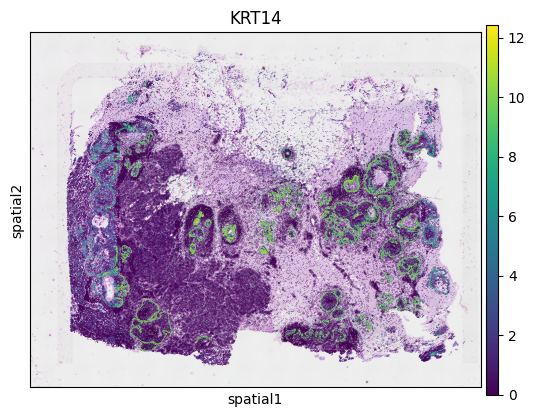

In [16]:
sc.pl.spatial(
    pred_adata,
    color="KRT14",        
    img_key='downscaled_fullres',          # 也可选，默认使用 'hires' 或 'lowres'
    spot_size=40,
    cmap="viridis",
    alpha=1,         # 点不透明
    alpha_img=1, 
    crop_coord=(0, pred_adata.uns['wsi_shape'][1], 0, pred_adata.uns['wsi_shape'][0])
)

/tmp/ipykernel_2172874/3823242417.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


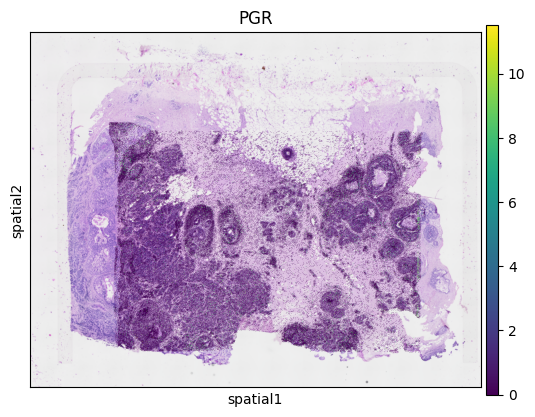

In [16]:
sc.pl.spatial(
    raw_adata,
    color="PGR",        
    img_key='downscaled_fullres',          # 也可选，默认使用 'hires' 或 'lowres'
    spot_size=30,
    cmap="viridis",
    alpha=1,         # 点不透明
    alpha_img=1, 
    crop_coord=(0, pred_adata.uns['wsi_shape'][1], 0, pred_adata.uns['wsi_shape'][0])
)

In [14]:
idx = search_idx(ref_embed, map_embed, 5)
# preds = gene_fusion(idx, xenium_adata.raw.X[train_index],5)
# pcc_mat = cal_PCC_features(xenium_adata.raw.X[test_index], preds)
preds = gene_fusion(idx, ref_gene,5)
pcc_mat = cal_PCC_features(map_gene, preds)
PCC_mat_clean = [v for v in pcc_mat if not np.isnan(v)]
print(np.mean(PCC_mat_clean))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [24]:
np.where(xenium_adata.var_names.values=='ESR1')[0]

array([194])

In [25]:
pcc_mat[194]

0.4119112

In [26]:
xenium_adata.obsm['spot_gene'][0]

ArrayView([243.1928   ,  66.361496 , 409.07407  ,  27.773949 ,
            64.62032  ,  87.098045 , 277.6177   , 215.01123  ,
           214.2735   , 337.88214  ,  54.74513  ,  93.20086  ,
            91.810936 , 110.49475  ,  15.221141 , 119.808556 ,
             9.488148 ,  26.040102 , 133.47263  , 381.27435  ,
           250.15472  , 341.2524   , 309.94623  ,  24.06917  ,
            18.850502 , 451.65134  , 524.96027  , 259.88754  ,
           181.32602  , 180.29411  ,  85.00406  , 226.72383  ,
            84.38276  ,  40.36351  , 224.35657  ,  89.989975 ,
            45.474007 ,  31.5562   ,   8.213663 ,   9.304742 ,
            20.733389 ,  32.999104 ,  19.731407 ,  26.823444 ,
            16.05689  ,   8.08897  , 409.9232   , 190.38095  ,
           586.53937  ,  42.419544 ,  16.60096  , 184.63739  ,
           178.5068   ,  37.003506 , 238.61014  ,  38.419643 ,
            26.520042 ,  51.334724 ,   0.       ,   0.       ,
            37.75815  ,  17.224947 ,   8.674018 ,   0. 

In [ ]:
pcc_mat[-50:]

0.5897068

In [55]:
xenium_adata_149.write('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer149_cell_TLS_HEST.h5ad')

In [74]:
all_ref_gene = np.concatenate([all_ref_gene, xenium_adata.obsm['spot_gene']])

In [75]:
all_ref_embed = np.concatenate([all_ref_embed, xenium_adata.obsm['virchow2_embed']])

In [69]:
gene_lt = xenium_adata_148.var_names.values

In [76]:
ref_data = {'ref_gene':all_ref_gene, 'ref_embed':all_ref_embed, 'gene_list':gene_lt}

In [ ]:
with open('/mnt/DATA16T/colon_cancer_HE/xenium_colon_cancer_ref_data.pickle', 'wb') as f:
	pickle.dump(ref_data, f)

In [80]:
with open('/mnt/DATA16T/colon_cancer_HE/WD-76845-001_rgb_virchow2_embedding.pickle', 'rb') as f:
	infer_data = pickle.load(f)

ModuleNotFoundError: No module named 'numpy._core'

In [63]:
xenium_adata_149

AnnData object with n_obs × n_vars = 306446 × 58
    obs: 'in_tissue', 'n_counts'
    uns: 'log1p', 'spatial', 'wsi_shape'
    obsm: 'img', 'spatial', 'spot_gene', 'virchow2_embed'

In [38]:
np.max(pcc_mat)

0.631016

In [36]:
new_adata = ann.AnnData(X = xenium_adata.raw.X)
new_adata.var_names = xenium_adata.var_names.values
new_adata.var['gene_id'] = xenium_adata.var['gene_id']

In [6]:
xenium_adata.var['gene_id'] = xenium_adata.var_names.values

In [17]:
crc_adata = sc.read_h5ad('/mnt/DATA16T/VisiumHD/Human_colon_cancer/TLS_Colon_Cancer_scgpt_fullembedding.h5ad')


In [4]:
crc111_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer1_nuc.h5ad')
crc147_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer147_nuc.h5ad')
crc148_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer148_nuc.h5ad')
crc149_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer149_nuc.h5ad')

In [5]:
crc111_adata.var['gene_id'] = crc111_adata.var_names.values
crc147_adata.var['gene_id'] = crc147_adata.var_names.values
crc148_adata.var['gene_id'] = crc148_adata.var_names.values
crc149_adata.var['gene_id'] = crc149_adata.var_names.values

In [ ]:
crc111_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer111_nuc_images_samples_50k.h5ad')

In [43]:
crc111_adata = sc.read_h5ad('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer111_spot_112_images.h5ad')

In [44]:
crc111_adata.var['gene_id'] = crc111_adata.var_names.values


In [7]:
def remove_zero_expression_cells(adata):
    # 检查每个细胞是否所有基因的表达值都为0
    non_zero_cells = (adata.X != 0).sum(axis=1) > 0  # 只保留至少有一个非零表达的细胞
    adata = adata[non_zero_cells, :]
    return adata

In [11]:
crc111_adata = crc111_adata[:,crc111_adata.var['id_in_vocab'].values>0]

In [48]:
crc111_adata = normalize_adata(crc111_adata)

In [51]:
crc111_adata = remove_zero_expression_cells(crc111_adata)

In [53]:
cell_bool = np.isin(crc111_adata.obs_names.values, crc_embed_adata.obs_names.values)

In [54]:
crc_embed_adata.obsm['raw_data'] = crc111_adata.X[cell_bool]

In [56]:
crc_111_adata_TLS = remove_zero_expression_cells(crc_111_adata_TLS)

In [10]:
xenium_adata = normalize_adata(xenium_adata)

In [11]:
xenium_adata = remove_zero_expression_cells(xenium_adata)

In [12]:
import pickle
with open('/mnt/DATA16T/VisiumHD/Human_colon_cancer/TLS_gene_list.pickle', 'rb') as f:
	TLS_list = pickle.load(f)

In [48]:
with open('/mnt/DATA16T/VisiumHD/Human_colon_cancer/crc_hvg.pickle', 'wb') as f:
	pickle.dump(tls_xenium_adata.var['gene_id'].values, f)

In [29]:
TLS_gene_bool = np.isin(xenium_adata.var['gene_id'].values, union_gene)

In [20]:
sc.pp.highly_variable_genes(
    xenium_adata,
    flavor="seurat_v3",  # 常用方法：'seurat_v3' / 'seurat' / 'cell_ranger' / 'pearson_residuals'
    n_top_genes=50,    # 或 min_mean / max_mean 等
    batch_key=None       # 如果多样本可以设置为 batch 字段
)

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:171: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [24]:
hvg = xenium_adata.var['gene_id'].values[xenium_adata.var['highly_variable'].values]

In [26]:
union_gene = list(set(hvg)|set(TLS_list))

In [30]:
tls_xenium_adata = xenium_adata[:, TLS_gene_bool]

In [36]:
tls_xenium_adata = tls_xenium_adata[:,tls_xenium_adata.var['id_in_vocab'].values>0]

In [37]:
tls_xenium_adata = remove_zero_expression_cells(tls_xenium_adata)

In [8]:
tls_xenium_adata = xenium_adata.copy()

In [9]:
tls_xenium_adata.X = xenium_adata.obsm['spot_gene']

In [ ]:
crc_embed_adata = scg.tasks.embed_data(
    tls_xenium_adata,
    model_dir,
    max_length=59,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
)

after version
scGPT - INFO - match 58/58 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 4299/4299 [01:23<00:00, 51.27it/s]
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:288: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [ ]:
tls_xenium_adata.obsm['gene_embed'] = crc_embed_adata.obsm['X_scGPT']

In [46]:
tls_xenium_adata.obsm['raw_data'] = xenium_adata.raw.X
tls_xenium_adata.obsm['all_gene'] = xenium_adata.X

In [45]:
xenium_adata = xenium_adata[tls_xenium_adata.obs_names.values]

In [12]:
crc_embed_adata.obsm['X_scGPT'].shape

(275120, 59, 512)

In [ ]:
xenium_adata.obsm['spot_embed'] = crc_embed_adata.obsm['X_scGPT']

In [46]:
xenium_adata.obsm['norm_data'] = new_adata.X

In [ ]:
xenium_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer147_cell_TLS_HEST.h5ad')

In [67]:
crc_embed_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer111_spot_112_images.h5ad')

In [12]:
crc_embed_adata_tls.obsm['fullgene_embed'] = crc_embed_adata.obsm['X_scGPT']

NameError: name 'crc_embed_adata_tls' is not defined

In [12]:
xenium_adata = xenium_adata[:, xenium_adata.var['id_in_vocab']>0]

In [ ]:
xenium_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Breast_Cancer785_spot_50_images.h5ad')

: 

In [24]:
xenium_adata.obsm['gene_embed'] = crc_embed_adata.obsm['X_scGPT']

In [41]:
crc_embed_adata_tls.obsm['virchow2_embed_64']=crc111_adata.obsm['virchow2_embed_64']

In [28]:
crc111_tls_adata = combine_embed_adata[combine_embed_adata.obs['batch_id']=='1']

In [19]:
crc_embed_adata.obsm['X_scGPT'].shape

(16406, 307, 512)

In [ ]:
xenium_adata

AnnData object with n_obs × n_vars = 16406 × 541
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts'
    var: 'gene_id', 'id_in_vocab'
    uns: 'log1p', 'noseq_img', 'noseq_spatial', 'noseq_virchow2_embed', 'spatial', 'wsi_shape'
    obsm: 'img', 'spatial', 'virchow2_embed'

In [35]:
crc111_adata

AnnData object with n_obs × n_vars = 585631 × 541
    obs: 'in_tissue', 'n_counts'
    var: 'gene_id'
    uns: 'log1p'
    obsm: 'spatial'

In [11]:
def normalize_adata(adata: AnnData, scale=1e6, smooth=False) -> AnnData: # type: ignore
    """
    Normalize each spot by total gene counts + Logarithmize each spot
    """
    
    import scanpy as sc
    
    filtered_adata = adata.copy()
    
    if smooth:
        adata_df = adata.to_df()
        for index, df_row in adata.obs.iterrows():
            row = int(df_row['array_row'])
            col = int(df_row['array_col'])
            neighbors_index = adata.obs[((adata.obs['array_row'] >= row - 1) & (adata.obs['array_row'] <= row + 1)) & \
                ((adata.obs['array_col'] >= col - 1) & (adata.obs['array_col'] <= col + 1))].index
            neighbors = adata_df.loc[neighbors_index]
            nb_neighbors = len(neighbors)
            
            avg = neighbors.sum() / nb_neighbors
            filtered_adata[index] = avg
    
    
    sc.pp.normalize_total(filtered_adata, target_sum=1, inplace=True)
    # Facilitate training when using the MSE loss. 
    # This'trick' is also used by Y. Zeng et al in "Spatial transcriptomics prediction from histology jointly through Transformer and graph neural networks"
    filtered_adata.X = filtered_adata.X * scale 
    
    # Logarithm of the expression
    sc.pp.log1p(filtered_adata) 
    filtered_adata.raw = adata

    return filtered_adata

In [18]:
crc3D_ref_adata = sc.read_h5ad('/mnt/DATA16T/colon_cancer_HE/GSM4804821_3907_AS2_CRC_mFilt_gficf.h5ad')

In [19]:
crc3D_ref_adata.var['gene_id']=crc3D_ref_adata.var_names.values

In [20]:
crc3D_ref_adata = normalize_adata(crc3D_ref_adata)

In [10]:
crc111_adata = normalize_adata(crc111_adata)
crc147_adata = normalize_adata(crc147_adata)
crc148_adata = normalize_adata(crc148_adata)
crc149_adata = normalize_adata(crc149_adata)

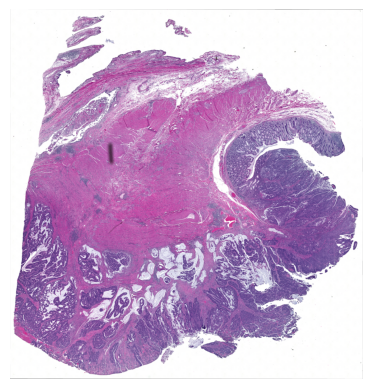

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/mnt/DATA16T/colon_cancer_HE/WD-76845-068_rgb.ome.tif')

# 生成缩略图（按比例缩小）
thumbnail_size = (1024, 1024)  # 目标尺寸
img.thumbnail(thumbnail_size)  # 会保持宽高比

# 显示缩略图
plt.imshow(img)
plt.axis('off')
plt.show()

In [62]:
crc111_adata.X[0]

array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , 12.42922,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     , 12.42922,  0.     , 12.42922,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.  

In [54]:
bool_gene = crc111_adata.var_names.isin(list(crc_adata.var['gene_id'].values))

In [55]:
crc_111_adata_TLS = crc111_adata[:, bool_gene]

In [37]:
crc_embed_adata

AnnData object with n_obs × n_vars = 49997 × 423
    obs: 'in_tissue', 'n_counts'
    var: 'gene_id', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'img', 'spatial', 'virchow2_embed', 'X_scGPT'

In [38]:
crc_111_adata_TLS.obsm['fullgene_embed']=crc_embed_adata.obsm['X_scGPT']

/tmp/ipykernel_190978/359262900.py:1: ImplicitModificationWarning: Setting element `.obsm['fullgene_embed']` of view, initializing view as actual.
  crc_111_adata_TLS.obsm['fullgene_embed']=crc_embed_adata.obsm['X_scGPT']


In [39]:
crc_111_adata_TLS

AnnData object with n_obs × n_vars = 49997 × 19
    obs: 'in_tissue', 'n_counts'
    var: 'gene_id', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'img', 'spatial', 'virchow2_embed', 'fullgene_embed'

In [28]:
crc147_adata_TLS = crc147_adata[:, bool_gene]

In [30]:
crc147_adata_TLS.var_names.values


array(['ACTA2', 'PECAM1', 'CXCL13', 'CD8A', 'CD68', 'MKI67', 'MS4A1',
       'IL7R', 'FCER2', 'CD79A', 'TRBC2', 'DES', 'CXCR5', 'CD274', 'CD3E',
       'CD3D', 'CD79B', 'FOXP3', 'CD3G'], dtype=object)

In [ ]:
crc_111_adata_TLS.var['gene_id'] = crc_111_adata_TLS.var_names.values
crc147_adata_TLS.var['gene_id'] = crc147_adata_TLS.var_names.values

Index(['CXCL13', 'KRT8', 'MS4A1', 'CXCR5', 'PECAM1', 'ACTA2', 'CD3D', 'CD3E',
       'FOXP3', 'IL7R', 'FCER2', 'TRBC2', 'CD79A', 'CD8A', 'CD3G', 'MKI67',
       'CD79B', 'CR2', 'PDCD1'],
      dtype='object')

In [3]:
breast_st = sc.read_h5ad('/mnt/DATA16T/hest_data/st/NCBI776.h5ad')

In [4]:
sc.pp.normalize_total(breast_st)
sc.pp.log1p(breast_st)

In [ ]:
breast_fresh = sc.read_h5ad('/mnt/DATA16T/VisiumHD/test_gpt_embeddings/breast_fixed_embedding.h5ad')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/DATA16T/VisiumHD/test_gpt_embeddings/breast_fixed_embedding_new.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
ref_data = breast_fresh.obsm['X_scGPT'][:18000]

In [8]:
map_data = breast_fresh.obsm['X_scGPT'][18000:]

In [14]:
pcc_list = []
for i in range(10):
	idx = search_idx(ref_data[:, i,:], map_data[:, i, :], 5)
	preds = gene_fusion(idx, breast_fresh.X.toarray()[:18000],5)
	pcc_mat = cal_PCC_features(breast_fresh.X.toarray()[18000:], preds)
	pcc_list.append(pcc_mat)
	PCC_mat_clean = [v for v in pcc_mat if not np.isnan(v)]
	print(np.mean(PCC_mat_clean))
	

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/tmp/ipykernel_832506/3645506914.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(label_feature, prediction_feature)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
pcc_list[2]

[-0.0030056402554791556,
 0.9623878832293051,
 0.17258260390150842,
 0.025948239309876664,
 0.008405439548431223,
 0.013613282588400208,
 0.0031615457082371963,
 0.024472028447577236,
 0.18552799460841476,
 0.1666488104926938,
 0.005500773265226138,
 nan,
 0.12142001622352874,
 0.38332298326109904,
 0.4381739496312623,
 0.36087759243880024,
 0.02487101258756689,
 -0.003741526875872123,
 0.10187970513010366,
 nan,
 0.02989148715198621,
 0.0735553631318182,
 -0.003761350597249324,
 0.04248320386992674,
 0.4430085113524195,
 0.05644103631201419,
 -0.006786753638132008,
 0.0038401340483205865,
 0.10260934959378842,
 0.12821093259711383,
 0.00047229574061795256,
 0.10705872384810097,
 0.32179269436903757,
 -0.0024877402000884866,
 0.08642076897180281,
 0.019950472342068183,
 0.0018682904873492372,
 0.05103951923761439,
 nan,
 0.16705933127052608,
 0.08942920531204311,
 0.20628715727154476,
 0.5339789953927131,
 nan,
 0.16673043967654838,
 -0.0011727835683651355,
 -0.0020675506706351217,
 0.

In [5]:
combined_adata = sc.read_h5ad('/home/whytin/Research/Project/scGPT/tutorials/data/breast_combined_adata_new.h5ad')

In [3]:
adata = sc.read_h5ad("/home/whytin/Research/Project/Liu_2022.processed.h5ad")

In [3]:
with open('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fixed_Frozen/Visium_HD_Human_Breast_Cancer_Fixed_Frozen_fullgenes_seq256_datasets_correct_new.pickle', 'rb') as f:
	fixed_dataset = pickle.load(f)


In [4]:
with open('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fresh_Frozen/Visium_HD_Human_Breast_Cancer_Fresh_Frozen_fullgenes_seq256_datasets_correct_new.pickle', 'rb') as f:
	breast_fresh_dataset = pickle.load(f)

In [4]:
with open('/mnt/DATA16T/VisiumHD/Human_colon_cancer/Visium_HD_Human_Colon_Cancer_fullgenes_seq256_datasets_correct.pickle', 'rb') as f:
	colon_dataset = pickle.load(f)

In [5]:
with open('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fresh_Frozen/Human_Breast_Cancer_Fresh_Frozen_gene_list.pkl', 'rb') as f:
	gene_list = pickle.load(f)

In [6]:
fixed_adata = ann.AnnData(X=fixed_dataset['gene'])

In [7]:
fresh_adata = ann.AnnData(X=breast_fresh_dataset['gene'])

In [6]:
colon_adata = ann.AnnData(X=colon_dataset['gene'])

In [27]:
test_adata.X[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [8]:
fixed_adata.var['gene_id'] = gene_list
fresh_adata.var['gene_id'] = gene_list

In [7]:
colon_adata.var['gene_id']=gene_list

In [29]:
sample_cells = np.random.choice(len(test_adata), 20000, replace=False)

In [30]:
test_adata=test_adata[sample_cells,:]

scGPT - INFO - match 16017/16032 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 744/744 [05:14<00:00,  2.36it/s]
/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


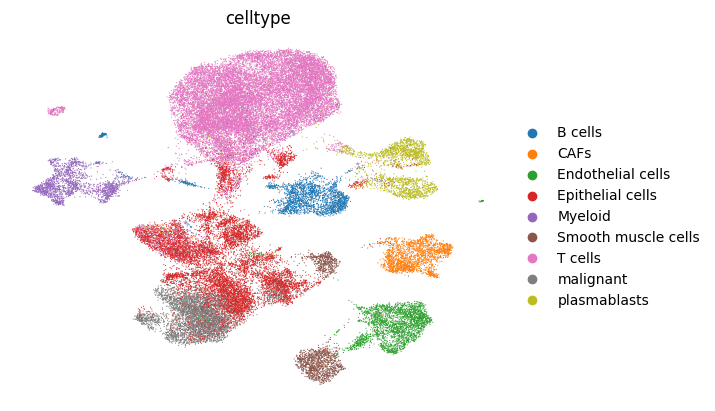

In [4]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

# # running on cpu, not recommended since it is slow
# ref_embed_adata = scg.tasks.embed_data(
#     adata,
#     model_dir,
#     gene_col=gene_col,
#     obs_to_save=cell_type_key,
#     batch_size=64,
#     device="cpu",
#     use_fast_transformer=False,
#     return_new_adata=True,
# )

# Optional step to visualize the reference dataset using the embeddings
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [18]:
#test_adata = sc.read_h5ad("../data/annotation_pancreas/demo_test.h5ad")
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

# # running on cpu
# test_embed_adata = scg.tasks.embed_data(
#     test_adata,
#     model_dir,
#     gene_col=gene_col,
#     obs_to_save=cell_type_key,
#     batch_size=64,
#     device="cpu",
#     use_fast_transformer=False,
#     return_new_adata=True,
# )

# # optional step to visualize the dataset
# sc.pp.neighbors(test_embed_adata, use_rep="X")
# sc.tl.umap(test_embed_adata)
# sc.pl.umap(test_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

scGPT - INFO - match 17840/18085 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 2155/2155 [15:22<00:00,  2.34it/s]


In [11]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [12]:
ref_cell_embeddings = ref_embed_adata.X
test_emebd = test2_embed_adata.X

k = 10  # number of neighbors

if faiss_imported:
    # Declaring index, using most of the default parameters from
    index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
    index.add(ref_cell_embeddings)

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
#gt = test2_adata.obs[cell_type_key].to_numpy()

#sklearn.metrics.accuracy_score(gt, preds)

['B cells',
 'malignant',
 'Smooth muscle cells',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'Epithelial cells',
 'malignant',
 'malignant',
 'Epithelial cells',
 'Smooth muscle cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'malignant',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cells',
 'Epithelial cel

In [21]:
test_adata.obs['celltype']=preds

In [24]:
test_embed_adata.obs['celltype']=preds

In [12]:
adata_combined = test2_embed_adata.concatenate(ref_embed_adata, batch_key='batch')

/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [35]:
adata

AnnData object with n_obs × n_vars = 47577 × 16032
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'patient', 'celltype', 'UMAP_1', 'UMAP_2'
    var: 'gene_id', 'id_in_vocab'

In [104]:
def remove_zero_expression_cells(adata):
    # 检查每个细胞是否所有基因的表达值都为0
    non_zero_cells = (adata.X != 0).sum(axis=1) > 0  # 只保留至少有一个非零表达的细胞
    adata = adata[non_zero_cells, :]
    return adata

def align_gene_order_and_modify_var(adata1, adata2):
    # 获取 raw_adata1_common 的 gene_id 顺序
    gene_order_adata1 = adata1.var['gene_id'].values
    
    # 根据 raw_adata1_common 的 gene_id 顺序重新排列 raw_adata2_common
    # 使用 pd.Index 对齐顺序
    adata2 = adata2[:, adata2.var['gene_id'].isin(gene_order_adata1)]  # 保证只保留相同基因
    adata2 = adata2[:, pd.Index(adata2.var['gene_id'].values).get_indexer(gene_order_adata1)]  # 按照 adata1 的顺序排序

    # 修改 raw_adata2_common 的 var['gene_id'] 以匹配 raw_adata1_common
    adata2.var['gene_id'] = gene_order_adata1

    return adata2


def combine_two_adata(adata, test_adata):
    # 获取 raw_adata1 和 raw_adata2 中的基因名称
    genes_adata1 = adata.var['gene_id']
    genes_adata2 = test_adata.var['gene_id']

    # 找到两个数据集的共同基因（交集）
    common_genes = genes_adata1[genes_adata1.isin(genes_adata2)].values

    # 提取包含共同基因的表达矩阵
    raw_adata1_common = adata[:, adata.var['gene_id'].isin(common_genes)]
    raw_adata2_common = test_adata[:, test_adata.var['gene_id'].isin(common_genes)]

    raw_adata2_common = align_gene_order_and_modify_var(raw_adata1_common, raw_adata2_common)

    raw_adata1_common.var_names = [str(i) for i in range(len(common_genes))]
    raw_adata2_common.var_names = [str(i) for i in range(len(common_genes))]
    # 合并两个数据集
    #raw_adata1_common.obs['batch_id']=raw_adata1_common.obs['batch']
    #raw_adata2_common.obs['batch_id']='5'
    combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')
    #combined_adata = ann.concat([raw_adata1_common, raw_adata2_common])
    #combined_adata = ann.concat([raw_adata1_common,raw_adata2_common], label='batch', keys=[None, '2'])
    combined_adata = remove_zero_expression_cells(combined_adata)

    return combined_adata
    # 可以选择保存结果，或者后续进行分析
    # combined_adata.write('combined_adata.h5ad')


In [30]:
combined_adata = combine_two_adata(crc_111_adata_TLS, crc3D_ref_adata)

/tmp/ipykernel_190978/3311837713.py:17: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata2.var['gene_id'] = gene_order_adata1
/tmp/ipykernel_190978/3311837713.py:41: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [33]:
tls_crc_adata = combined_adata[combined_adata.obs['batch']=='0']

In [35]:
tls_crc_adata.obs_names

Index(['554543-0', '462567-0', '119484-0', '356235-0', '317763-0', '465978-0',
       '516392-0', '440958-0', '144309-0', '131873-0',
       ...
       '122194-0', '271745-0', '460625-0', '384490-0', '91282-0', '548962-0',
       '545196-0', '56509-0', '574783-0', '10953-0'],
      dtype='object', length=40514)

In [81]:
combined_adata

View of AnnData object with n_obs × n_vars = 994946 × 16
    obs: 'in_tissue', 'n_counts', 'batch', 'batch_id'
    var: 'gene_id', 'id_in_vocab-0-0-0-0-0'

In [64]:
genes_adata1 = adata2.var['gene_id']
genes_adata2 = adata3.var['gene_id']

In [78]:
common_genes = genes_adata1[genes_adata1.isin(genes_adata2)].values
raw_adata1_common = adata2[:, adata2.var['gene_id'].isin(common_genes)]
raw_adata2_common = adata3[:, adata3.var['gene_id'].isin(common_genes)]

In [79]:
raw_adata2_common = align_gene_order_and_modify_var(raw_adata1_common, raw_adata2_common)

/tmp/ipykernel_676860/1052665007.py:17: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata2.var['gene_id'] = gene_order_adata1


In [9]:
breast_st.var['gene_id']=breast_st.var_names

In [10]:
#combined_adata = combine_two_adata(adata, test_adata)
#combined_adata = combine_two_adata(combined_adata, test_adata)
combined_adata = combine_two_adata(combined_adata, breast_st)

/tmp/ipykernel_2472256/754750241.py:17: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata2.var['gene_id'] = gene_order_adata1
/tmp/ipykernel_2472256/754750241.py:41: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')


In [18]:
combined_adata

View of AnnData object with n_obs × n_vars = 349661 × 14637
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'patient', 'celltype', 'UMAP_1', 'UMAP_2', 'batch', 'batch_id', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_id', 'gene_ids-1', 'feature_types-1', 'genome-1', 'mito-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1'

In [15]:
adata2 = sc.read_h5ad('/home/whytin/Research/Project/Wu_2021.processed.h5ad')
sc.pp.normalize_total(adata2)
sc.pp.log1p(adata2)

In [16]:
adata3 = sc.read_h5ad('/home/whytin/Research/Project/Xu_2021.processed.h5ad')
sc.pp.normalize_total(adata3)
sc.pp.log1p(adata3)

In [17]:
adata4 = sc.read_h5ad('/home/whytin/Research/Project/Bhupinder_2021.processed.h5ad')
sc.pp.normalize_total(adata4)
sc.pp.log1p(adata4)

In [27]:
combined_adata

View of AnnData object with n_obs × n_vars = 67577 × 15231
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'patient', 'celltype', 'UMAP_1', 'UMAP_2', 'batch'
    var: 'gene_id'

In [23]:
combined_adata = combine_two_adata(combined_adata, adata4)

/tmp/ipykernel_2084146/2177117519.py:17: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata2.var['gene_id'] = gene_order_adata1
/tmp/ipykernel_2084146/2177117519.py:41: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')


In [46]:
np.unique(combined_adata.obs['batch_id'].values)

array(['0', '1', '2', '3', '4'], dtype=object)

In [33]:
combined_adata.write('/home/whytin/Research/Project/scGPT/tutorials/data/breast_combined_adata_new.h5ad')

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [124]:
raw_adata1_common.var_names = list(map(str, range(15231)))

In [126]:
raw_adata2_common.var

gene_id
0        SAMD11
1         NOC2L
2        KLHL17
3       PLEKHN1
4         PERM1
...         ...
15226  C12orf56
15227       TTR
15228     IGFL1
15229    VPREB1
15230     IGLL1

[15231 rows x 1 columns]

In [127]:
combined_adata = raw_adata1_common.concatenate(raw_adata2_common, batch_key='batch')


/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [3]:
combined_adata = sc.read_h5ad('/home/whytin/Research/Project/scGPT/tutorials/data/breast_combined_adata.h5ad')

In [4]:
len(combined_adata.var['gene_id'])

14637

In [ ]:
breast_fixed_adata = combined_adata[combined_adata.obs['batch_id']=='1', :]

In [8]:
print("Number of inf values in adata.X:", np.isinf(combined_adata.X.toarray()).sum())

Number of inf values in adata.X: 0


In [12]:
sc.pp.filter_genes(combined_adata, min_cells=0)

In [3]:
sc.pp.log1p(combined_adata)

In [11]:
mt =combined_adata.X.toarray()

In [32]:
np.unique(adata.X[0])

array([0.        , 1.59738766, 2.1838264 , 2.55103227, 2.81902142,
       3.03016035, 3.204398  , 3.35273419, 3.48188242, 3.596243  ,
       3.69885709, 3.79191457, 3.87704482, 3.95549303, 4.02823226,
       4.09603738, 4.15953545, 4.21924113, 4.275582  , 4.32891717,
       4.37955115, 4.42774443, 4.4737215 , 4.51767728, 4.71243669,
       4.7472182 , 4.78083052, 4.84484459, 4.87537777, 4.90500623,
       5.09095195, 5.16114997, 5.36488176])

In [12]:
index = np.argmax(mt)

# 将索引转换为行和列的位置
row, col = np.unravel_index(index, mt.shape)

In [8]:
np.max(combined_adata[combined_adata.obs['batch_id']=='5', :].X.toarray()[0])

1.351569527808446

In [4]:
sc.pp.highly_variable_genes(combined_adata, flavor='seurat', n_top_genes=1000)

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [39]:
combined_adata

AnnData object with n_obs × n_vars = 344669 × 14637
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'patient', 'celltype', 'UMAP_1', 'UMAP_2', 'batch', 'batch_id'
    var: 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'id_in_vocab'
    uns: 'hvg'

In [5]:
combined_adata = combined_adata[:,combined_adata.var['highly_variable']]

In [11]:
breast_fixed_adata=combined_adata[combined_adata.obs['batch_id']=='3',:]

In [11]:
zero_cells = np.all(fixed_adata.X == 0, axis=1)

# 获取要删除的细胞的索引
cells_to_remove = np.where(zero_cells)[0]

# 删除全为0的细胞
fixed_adata = fixed_adata[~zero_cells, :]

In [3]:
fixed_adata = sc.read_h5ad('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fixed_Frozen/Visium_HD_Human_Breast_Cancer_Fixed_Frozen_fullgenes_embedding.h5ad')

In [7]:
breast_fixed_embed_adata = scg.tasks.embed_data(
    fixed_adata,
    model_dir,
    gene_col=gene_col,
    max_length=len(fixed_adata.var['gene_id']),
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=8,
    return_new_adata=False,
)

scGPT - INFO - match 17840/18085 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 34178/34178 [35:24<00:00, 16.09it/s] 
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [15]:
zero_cells_fresh = np.all(fresh_adata.X == 0, axis=1)

# 获取要删除的细胞的索引
cells_to_remove = np.where(zero_cells_fresh)[0]

# 删除全为0的细胞
fresh_adata = fresh_adata[~zero_cells_fresh, :]

In [11]:
fresh_adata = sc.read_h5ad('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fresh_Frozen/Visium_HD_Human_Breast_Cancer_Fresh_Frozen_fullgenes_embedding.h5ad')

In [12]:
breast_fresh_embed_adata = scg.tasks.embed_data(
    fresh_adata,
    model_dir,
    gene_col=gene_col,
    max_length=len(fixed_adata.var['gene_id']),
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=8,
    return_new_adata=False,
)

scGPT - INFO - match 17840/18085 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 17240/17240 [39:03<00:00,  7.36it/s]
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [8]:
fixed_adata.obsm['X_scGPT']=breast_fixed_embed_adata.obsm['X_scGPT']
#fixed_adata.obsm['non_zero_index']=np.array(range(len(zero_cells)))[~zero_cells]
#fixed_adata.obsm['spatial']=fixed_dataset['spatial'][~zero_cells]
fixed_adata.write('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fixed_Frozen/Visium_HD_Human_Breast_Cancer_Fixed_Frozen_fullgenes_embedding.h5ad')

(273421, 512)

In [13]:
fresh_adata.obsm['X_scGPT']=breast_fresh_embed_adata.obsm['X_scGPT']
#fresh_adata.obsm['non_zero_index']=np.array(range(len(zero_cells_fresh)))[~zero_cells_fresh]
#fresh_adata.obsm['spatial']=breast_fresh_dataset['spatial'][~zero_cells_fresh]
fresh_adata.write('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fresh_Frozen/Visium_HD_Human_Breast_Cancer_Fresh_Frozen_fullgenes_embedding.h5ad')

In [8]:
zero_cells_colon = np.all(colon_adata.X == 0, axis=1)

# 获取要删除的细胞的索引
cells_to_remove = np.where(zero_cells_colon)[0]

# 删除全为0的细胞
colon_adata = colon_adata[~zero_cells_colon, :]

In [14]:
colon_adata = sc.read_h5ad('/mnt/DATA16T/VisiumHD/Human_colon_cancer/Visium_HD_Human_Colon_Cancer_fullgenes_embedding.h5ad')

In [15]:
colon_embed_adata = scg.tasks.embed_data(
    colon_adata,
    model_dir,
    gene_col=gene_col,
    max_length=len(colon_adata.var['gene_id']),
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=8,
    return_new_adata=False,
)

scGPT - INFO - match 17840/18085 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(


Embedding cells: 100%|██████████| 37033/37033 [49:46<00:00, 12.40it/s]  
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [16]:
colon_adata.obsm['X_scGPT']=colon_embed_adata.obsm['X_scGPT']
#colon_adata.obsm['non_zero_index']=np.array(range(len(zero_cells_colon)))[~zero_cells_colon]
#colon_adata.obsm['spatial']=colon_dataset['spatial'][~zero_cells_colon]
colon_adata.write('/mnt/DATA16T/VisiumHD/Human_colon_cancer/Visium_HD_Human_Colon_Cancer_fullgenes_embedding.h5ad')

In [ ]:
del fixed_adata
del fresh_adata

In [14]:
breast_fixed_embed_adata.write('/mnt/DATA16T/VisiumHD/test_gpt_embeddings/breast_Xu_embedding.h5ad')

In [24]:
combine_embed_adata = scg.tasks.embed_data(
    combined_adata,
    model_dir,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 16/16 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:212: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 15547/15547 [00:52<00:00, 298.22it/s]
/home/whytin/Research/Project/scGPT/tutorials/../scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [26]:
combine_embed_adata.write('/mnt/DATA16T/Xenium/Xenium_Human_Colon_Cancer_ref_embeddings.h5ad')

In [5]:
test2_adata = sc.read_h5ad('/home/whytin/Research/Project/Xu_2021.processed.h5ad')

In [6]:
test2_embed_adata = scg.tasks.embed_data(
    test2_adata,
    model_dir,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 15517/15532 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 419/419 [02:35<00:00,  2.69it/s]


In [135]:
combine_embed_adata.obs['batch']=combined_adata.obs['batch'].values

In [139]:
combine_embed_adata.obs['batch']

0         0
1         0
2         0
3         0
4         0
         ..
185489    1
185490    1
185491    1
185492    1
185493    1
Name: batch, Length: 185494, dtype: category
Categories (2, object): ['0', '1']

In [151]:
np.max(adata.X)

8.745039084432898

In [153]:
np.max(test_adata.X)

19.857317

In [9]:
test2_embed_adata.obs['celltype'] = test2_adata.obs['celltype'].values

/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


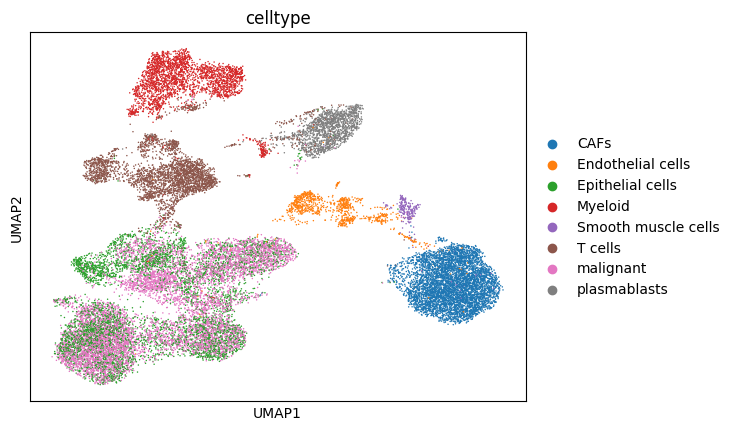

In [10]:
sc.pp.neighbors(test2_embed_adata)
sc.tl.umap(test2_embed_adata)
sc.pl.umap(test2_embed_adata, color='celltype')

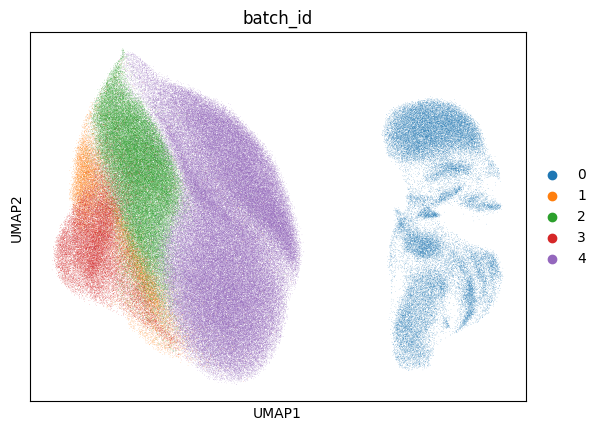

In [ ]:
combine_embed_adata.obs['batch_id'] = combined_adata.obs['batch_id'].values
sc.pl.umap(combine_embed_adata, color='batch_id')

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spec

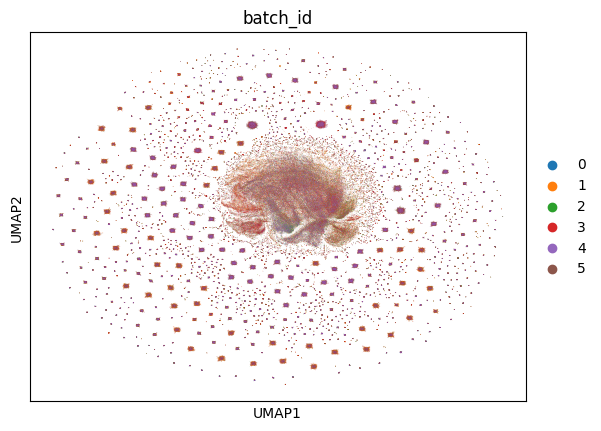

In [88]:
#combine_embed_adata = test_embed_adata.concatenate(ref_embed_adata, batch_key='batch')
combine_embed_adata.obs['batch_id'] = combined_adata.obs['batch_id'].values
sc.pp.neighbors(combine_embed_adata)
sc.tl.umap(combine_embed_adata)
sc.pl.umap(combine_embed_adata, color='batch_id')


In [ ]:
sc.pp.neighbors(combined_adata)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color='batch_id')

In [11]:
with open('/mnt/DATA16T/VisiumHD/Human_colon_cancer/TLS_gene_list.pickle', 'rb') as f:
	tls_gene = pickle.load(f)

In [12]:
tls_adata = combined_adata[:, combined_adata.var['gene_id'].isin(tls_gene)]

In [13]:
tls_adata = remove_zero_expression_cells(tls_adata)

In [12]:
tls_fixed_adata = fixed_adata[:, fixed_adata.var['gene_id'].isin(tls_gene)]
tls_fresh_adata = fresh_adata[:, fresh_adata.var['gene_id'].isin(tls_gene)]

In [19]:
non_zero_cells = (tls_fresh_adata.X != 0).sum(axis=1) > 0  # 只保留至少有一个非零表达的细胞
tls_fresh_adata = tls_fresh_adata[non_zero_cells, :]

In [16]:
tls_fixed_adata.obsm['non_zero_index']= np.array(range(len(non_zero_cells)))[non_zero_cells]

/tmp/ipykernel_2565736/2451550505.py:1: ImplicitModificationWarning: Setting element `.obsm['non_zero_index']` of view, initializing view as actual.
  tls_fixed_adata.obsm['non_zero_index']= np.array(range(len(non_zero_cells)))[non_zero_cells]


In [20]:
tls_fresh_adata.obsm['non_zero_index']= np.array(range(len(non_zero_cells)))[non_zero_cells]

/tmp/ipykernel_2565736/1695880562.py:1: ImplicitModificationWarning: Setting element `.obsm['non_zero_index']` of view, initializing view as actual.
  tls_fresh_adata.obsm['non_zero_index']= np.array(range(len(non_zero_cells)))[non_zero_cells]


In [23]:
tls_fixed_embed_adata = scg.tasks.embed_data(
    tls_fixed_adata,
    model_dir,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 31/31 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 3106/3106 [00:26<00:00, 115.78it/s]
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [24]:
tls_fresh_embed_adata = scg.tasks.embed_data(
    tls_fresh_adata,
    model_dir,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 31/31 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 2080/2080 [00:23<00:00, 89.96it/s] 
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [31]:
tls_fixed_adata.obsm['X_scGPT']=tls_fixed_embed_adata.X
tls_fresh_adata.obsm['X_scGPT']=tls_fresh_embed_adata.X

In [32]:
tls_fixed_adata.write('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fixed_Frozen/TLS_Fixed_Breast_Cancer_scgpt_fullembedding.h5ad')
tls_fresh_adata.write('/mnt/DATA16T/VisiumHD/Human_Breast_Cancer_Fresh_Frozen/TLS_Fresh_Breast_Cancer_scgpt_fullembedding.h5ad')

In [15]:
tls_embed_adata.obs['batch_id'] = tls_adata.obs['batch_id'].values
sc.pp.neighbors(tls_embed_adata)
#sc.tl.umap(tls_embed_adata)
#sc.pl.umap(tls_embed_adata, color='batch_id')


/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [16]:
sc.tl.umap(tls_embed_adata)

/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/umap/s

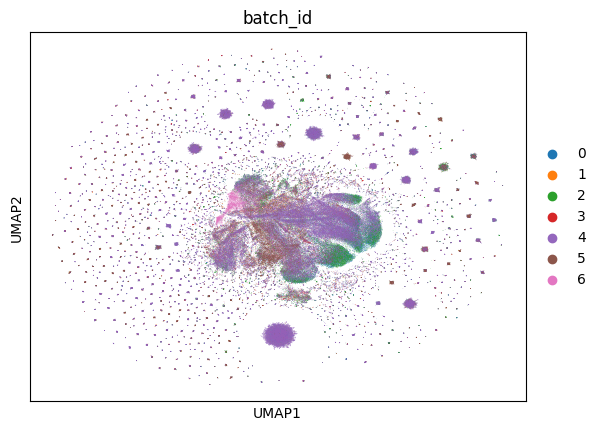

In [17]:
sc.pl.umap(tls_embed_adata, color='batch_id')

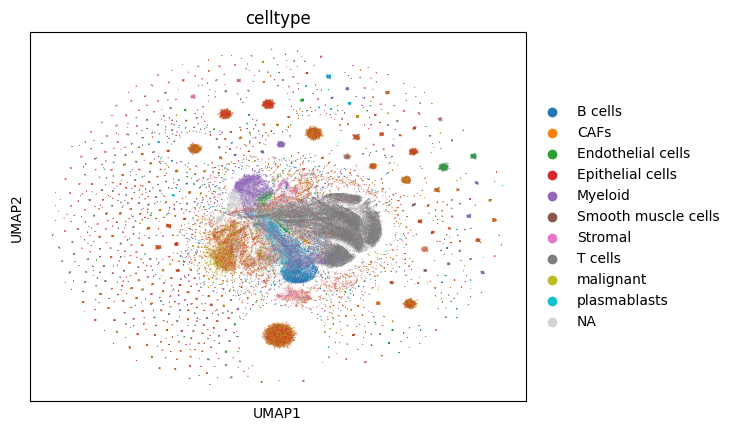

In [20]:
tls_embed_adata.obs['celltype'] = tls_adata.obs['celltype'].values
sc.pl.umap(tls_embed_adata, color='celltype')

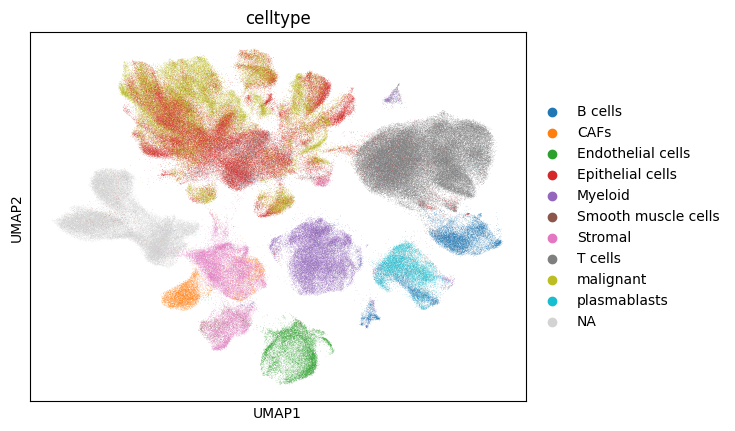

In [7]:
combine_embed_adata.obs['celltype'] = combined_adata.obs['celltype'].values
sc.pl.umap(combine_embed_adata, color='celltype')

In [8]:
test_adata = combined_adata[combined_adata.obs['batch_id']=='5', :]

In [80]:
test_embed_adata = scg.tasks.embed_data(
    raw_adata2_common,
    model_dir,
    gene_col=gene_col,
    #obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
    return_new_adata=True,
)

scGPT - INFO - match 15496/15511 genes in vocabulary of size 60697.


/home/whytin/Research/Project/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 419/419 [02:35<00:00,  2.70it/s]
/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/home/whytin/miniconda3/envs/scgpt310/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


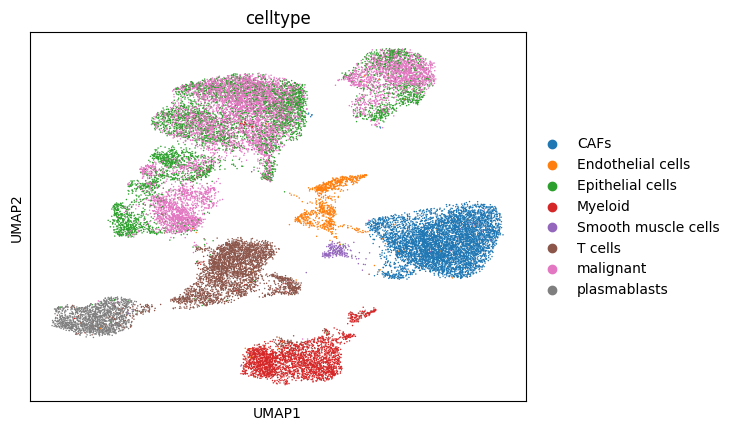

In [81]:
test_embed_adata.obs['celltype'] = raw_adata2_common.obs['celltype'].values
sc.pp.neighbors(test_embed_adata)
sc.tl.umap(test_embed_adata)
sc.pl.umap(test_embed_adata, color='celltype')

In [10]:
combine_embed_adata.obs['celltype']=combined_adata.obs['celltype'].values

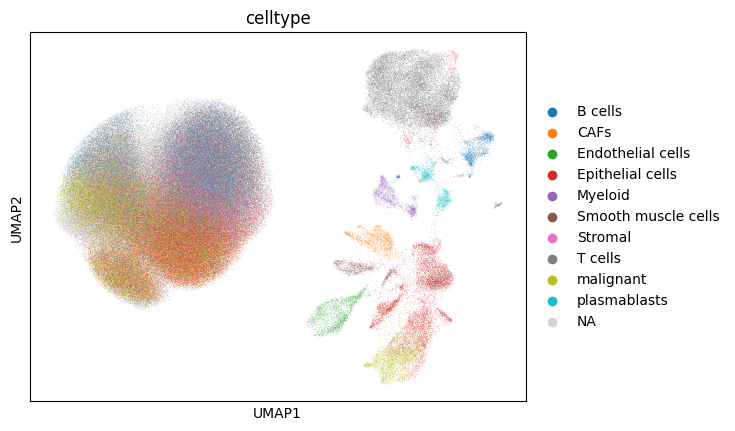

In [11]:
sc.pl.umap(combine_embed_adata, color='celltype')


In [16]:
map_breast = combine_embed_adata[combine_embed_adata.obs['batch_id']=='1',:]

In [17]:
ref_breast = combine_embed_adata[combine_embed_adata.obs['batch_id']!='1',:]

In [13]:
map_breast

View of AnnData object with n_obs × n_vars = 20000 × 512
    obs: 'batch_id'
    uns: 'pca', 'neighbors', 'umap', 'batch_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
from scipy.stats import pearsonr
def get_pcc(adata1,adata2,dim=1,func=pearsonr):
    r1,p1=[],[]
    for g in range(adata1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g])
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:])
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def cal_PCC_features(target, predict):
      n_features = target.shape[1]
      # 存储每个特征的皮尔森相关系数
      pcc_values = []
      # 按照每个特征计算皮尔森相关系数
      for i in range(n_features):
          label_feature = target[:, i].flatten()
          prediction_feature = predict[:, i].flatten()
          # 计算皮尔森相关系数
          corr, _ = pearsonr(label_feature, prediction_feature)
          # 将结果添加到列表
          pcc_values.append(corr)
      return pcc_values       

import faiss
def search_idx(ref_emb, map_emb, k_neighbors):
	k=k_neighbors
	index = faiss.IndexFlatL2(ref_emb.shape[1])
	index.add(ref_emb)
	# Query dataset, k - number of closest elements (returns 2 numpy arrays)
	distances, labels = index.search(map_emb, k)
	return labels

def gene_fusion(idx, gene_ref, ref_num=50):
	val_mean_output = []
	for i in range(len(idx)):
		k_neighbor = []
		print(i)
		for j in idx[i][:ref_num]:
			k_neighbor.append(gene_ref[j])
		val_mean_output.append(np.mean(np.array(k_neighbor), axis=0))
	return np.array(val_mean_output)

In [19]:
idx = search_idx(ref_breast.X, map_breast.X, 10)

In [24]:
pred_genes = gene_fusion(idx, combined_adata[combined_adata.obs['batch_id']!='1',:].X.toarray(), 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1]:
pred_genes

NameError: name 'pred_genes' is not defined

In [25]:
pcc_mat = cal_PCC_features(combined_adata[combined_adata.obs['batch_id']=='1',:].X.toarray(), pred_genes)
PCC_mat_clean = [v for v in pcc_mat if not np.isnan(v)]
PCC_sorted = sorted(PCC_mat_clean, reverse=True)


/tmp/ipykernel_634266/3645506914.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(label_feature, prediction_feature)


In [28]:
combined_adata.obs['batch_id']

CA1_AAACCTGAGAGGTAGA-0-0-0-0-0    0
CA1_AAACCTGAGCCCAACC-0-0-0-0-0    0
CA1_AAACCTGAGCGTTTAC-0-0-0-0-0    0
CA1_AAACCTGAGTCCGTAT-0-0-0-0-0    0
CA1_AAACCTGCAAGTAATG-0-0-0-0-0    0
                                 ..
153249-1                          5
162037-1                          5
176426-1                          5
68670-1                           5
115527-1                          5
Name: batch_id, Length: 344669, dtype: object

In [26]:
PCC_sorted

[0.37857925855370866,
 0.3688395884685677,
 0.3599191958622983,
 0.3521460020819658,
 0.35034390407264016,
 0.3485170174696145,
 0.34788404108890064,
 0.3448631997530237,
 0.3410692899296075,
 0.33622763536499495,
 0.3119189583893732,
 0.30705633789075876,
 0.3041531936045446,
 0.2969670346476151,
 0.2912911297902509,
 0.2868013482564878,
 0.2823148911002065,
 0.2795315301404252,
 0.27812016194878675,
 0.2769580869751359,
 0.2765292826688546,
 0.27562891452126626,
 0.2722308942853224,
 0.26939955765006546,
 0.2649426140239278,
 0.26375593042269097,
 0.26316161571981933,
 0.2627483221197166,
 0.2597937788812626,
 0.2577978836746183,
 0.25559190744541865,
 0.25455097071920474,
 0.2544048972364412,
 0.2542352543298091,
 0.25354292165648507,
 0.25214478505671106,
 0.2503708245156458,
 0.2499639318688921,
 0.24806961713000825,
 0.24763793094463696,
 0.24700605831674538,
 0.24622412211948086,
 0.24524797751470312,
 0.24502114862008317,
 0.2429898784294775,
 0.24279558285874164,
 0.2409353194

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


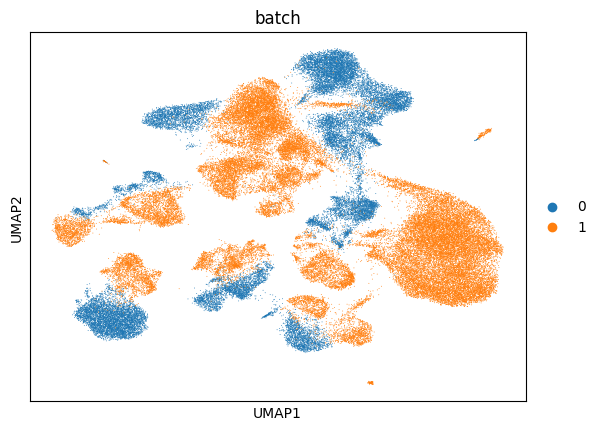

In [13]:
sc.pp.neighbors(adata_combined)
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color='batch')

In [22]:
ref_embed_adata

AnnData object with n_obs × n_vars = 47577 × 512
    obs: 'celltype'
    uns: 'neighbors', 'umap', 'celltype_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [7]:
# # optionally, the built index can be saved/loaded for future use
# faiss.write_index(index, "index.faiss")
# index = faiss.read_index("index.faiss")

## Reference mapping using the CellXGene atlas

We have previously built the index for all the cells in normal or cancer samples, over 33 million cells in total. You can find the code to build the index at [build_atlas_index_faiss.py](build_atlas_index_faiss.py).
We applied careful tuning to eventually well balance between the accuracy and efficiency. Now the actual building process takes less than 3 minutes and we choose to use only 16 bytes to store the vector per cell, which leads to 808 MB for the whole index of all the millions of cells. Please download the faiss index folder from https://drive.google.com/drive/folders/1q14U50SNg5LMjlZ9KH-n-YsGRi8zkCbe?usp=sharing.

Faiss is required to use the index. Please install it by following the instructions at https://github.com/facebookresearch/faiss/wiki/Installing-Faiss

In [1]:
from build_atlas_index_faiss import load_index, vote

/home/whytin/miniconda3/envs/scgpt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import faiss

In [4]:
use_gpu = faiss.get_num_gpus() > 0
index, meta_labels = load_index(
    index_dir="/home/whytin/Research/Project/scGPT/save/CellXGene_faiss_index",
    use_config_file=False,
    use_gpu=use_gpu,
)
print(f"Loaded index with {index.ntotal} cells")


Loading index and meta from /home/whytin/Research/Project/scGPT/save/CellXGene_faiss_index ...
Index loaded, num_embeddings: 35096827
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 35096827 cells


The search runs super fast, especially on GPU. Here the similarity search for 4,000 query cells within the whole reference of millions should take around 7 second on CPU and 0.1 second on GPU.

In [10]:
%%time
k = 50
# test with the first 100 cells
distances, idx = index.search(test_emebd, k)

CPU times: user 252 ms, sys: 493 ms, total: 745 ms
Wall time: 133 ms


Here, we propagate the previously saved cell type labels, `meta_label`, from CellXGene annotations by majority voting.

In [11]:
predict_labels = meta_labels[idx]
# from scipy.stats import mode
from tqdm import tqdm

voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)

100%|██████████| 4218/4218 [00:00<00:00, 20353.06it/s]


In [18]:
print(gt[:10])   # Original labels in the query dataset, used for evaluation
print(voting[:10])  # Propagated CellXGene labels

['beta' 'beta' 'beta' 'beta' 'PSC' 'beta' 'beta' 'beta' 'ductal' 'alpha']
['neuroendocrine cell' 'classical monocyte' 'neuroendocrine cell'
 'neuroendocrine cell' 'mural cell' 'classical monocyte' 'stromal cell'
 'myeloid cell' 'malignant cell' 'stromal cell']


Currently, we found the CellXGene labels are scattered in different levels of the cell type hieratchy, with more generic cell types such as stromal cells in great abundance. The difference in the number of cells in each cell type may lead to less useful annotations, even though the similarity search itself may be sufficiently accurate. We are working on a better way to curate the cell type labels in a consistent way. Our current idea is plan to apply hierarchical predictions and provide a spectrum of cell type labels for each cell, from generic to more specific cell types.

You may see the proportion of cell types in the meta labels by running
```python
from build_atlas_index_faiss import compute_category_proportion
compute_category_proportion(meta_labels)
```

Meanwhile, the propagation of major cell types is usually more accurate. An example with endothelial cells is provided as follows. 

In [19]:
# find the endothelial cells
ids_m = np.where(gt == "endothelial")[0]
print(f"Found {len(ids_m)} endothelial cells")
print(f"Predicted cell types: {voting[ids_m]}")
print(f"Annotated cell types: {gt[ids_m]}")

Found 16 endothelial cells
Predicted cell types: ['capillary endothelial cell' 'capillary endothelial cell'
 'endothelial cell of vascular tree' 'endothelial cell' 'endothelial cell'
 'endothelial cell' 'endothelial cell' 'endothelial cell'
 'endothelial cell' 'endothelial cell' 'endothelial cell'
 'endothelial cell' 'endothelial cell of vascular tree' 'endothelial cell'
 'endothelial cell' 'vein endothelial cell']
Annotated cell types: ['endothelial' 'endothelial' 'endothelial' 'endothelial' 'endothelial'
 'endothelial' 'endothelial' 'endothelial' 'endothelial' 'endothelial'
 'endothelial' 'endothelial' 'endothelial' 'endothelial' 'endothelial'
 'endothelial']
